# Small baseline time series analysis with pysarApp

There are two groups of InSAR time series techniques: persistent scatterer (PS) methods, which focus on the phase-stable point scatterers, and distributed scatterer (DS) methods, which relaxed the strict limit on the phase stability and included areas that are affected by decorrelation through the exploitation of the redundant network of interferograms. In this notebook we focus on the DS method, and more specifically, the DS method with the network of small baseline interferograms (SBAS) using pysarApp.py

The detailed algorithms and mathematical formulations implemented in PySAR software can be found in the literature: Yunjun, Z., H. Fattahi, F. Amelung (2019), InSAR time series analysis: error correction and noise reduction, _Remote Sensing of Environment_ (under review).      

# pysarApp (general overview)

pysarApp.py is a PySAR script for the routine processing workflow of InSAR time series analysis. The script takes a stack of coregistered and unwrapped interferograms and generates the displacement time-series. The workflow consists of two main blocks:   
+ correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),   
+ correcting for noise from different sources to obtain the displacement time-series (green ovals).    

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [pysarApp_template.txt](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp_template.txt). In this notebook, we will walk through the various steps.      
     
<p align="left">
  <img width="600" src="docs/images/pysarApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

The input is a stack of **phase-unwrapped** interferograms **coregistered to a common SAR acquisition**, corrected for earth curvature and topography, which are referred hereafter as a **InSAR stack**. PySAR currently supports InSAR stacks produced by ISCE, GAMMA and ROI_PAC software (Rosen et al., 2004; 2012; Werner et al., 2000). Some example file/directory structures are shown through the links below:

- [ISCE/topsStack](docs/dir_isce_tops.ipynb)
- [ISCE/stripmapStack](docs/dir_isce_stripmap.ipynb)
- [GAMMA](docs/dir_gamma.ipynb)
- [ROI_PAC](docs/dir_roipac.ipynb)

### Example dataset
Here we use the InSAR stack from Sentinel-1 satellite descending track 128 acquired over Fernandina volcano, Galapagos, Ecuador as an example ([Zenodo](https://zenodo.org/record/2571980); ~750M in size). It spans from 2014-12-13 to 2018-06-19 with 98 acquisitions in total. We use the stack Sentinel processor (Fattahi et al., 2016) within ISCE (Rosen et al., 2012) for processing the InSAR stack.     

<p align="left">
  <img src="docs/images/FernandinaSenDT128_unwrapPhase_wrap.png">
</p>     

## 0. Initial setup of the notebook

The cell below performs the intial setup of the notebook and **must be run every time the notebook (re)starts**. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from pysar.objects import ifgramStack
from pysar.utils import plot as pp, utils as ut
from pysar.view import viewer

# define the work directory
work_dir = os.path.expanduser('~/work')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print('Create directory: {}'.format(work_dir))
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download the example dataset
proj_name = 'FernandinaSenDT128'
tar_file = '{}.tar.xz'.format(proj_name)
if not os.path.isfile(tar_file):
    !wget https://zenodo.org/record/2571980/files/FernandinaSenDT128.tar.xz
else:
    print('{} exists.'.format(tar_file))

if not os.path.isdir(proj_name):
    cmd = 'tar -xJf FernandinaSenDT128.tar.xz'
    print('uncompressing the tar file:', cmd, '...')
    !{cmd}

# go to the PYSAR directory
proj_dir = os.path.join(work_dir, '{}/PYSAR'.format(proj_name))
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

# visualization functions
def view(fname):
    """Plot input file using view.py script from PySAR"""
    cmd = 'view.py {} --noverbose --notick --noaxis'.format(fname)
    print(cmd)
    obj = viewer(cmd)
    obj.configure()
    obj.plot()
    return

Go to work directory: /Users/yunjunz/work
FernandinaSenDT128.tar.xz exists.
uncompressing the tar file: tar -xJf FernandinaSenDT128.tar.xz ...
Go to project directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR


## 1. Setting up template file

The configuration parameters to pysarApp.py are controlled through two template files. At least one template is required to run pysarApp.py.    

+ `default template`: [pysarApp_template.txt](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp_template.txt). It contains all configuration parameters, grouped by steps, with default _auto_ values (which are defined in [pysarApp.cfg](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp.cfg)). This file is read every time pysarApp.py runs.      
      
      
+ `custom template` (optional but recommended): FernandinaSenDT128.txt in the example dataset. It constains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the default template; if custom template is input, pysarApp.py will update the default pysarApp_template.txt file accordingly.       

### Custom template example

The path of all input files (`pysar.load.*`) and the reference point (`pysar.reference.*`) are always recommended. Below are from FernandinaSenDT128.txt file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
pysar.load.processor        = isce
##---------for ISCE only:
pysar.load.metaFile         = ../ISCE/master/IW*.xml
pysar.load.baselineDir      = ../ISCE/baselines
##---------interferogram datasets:
pysar.load.unwFile          = ../ISCE/merged/interferograms/*/filt_*.unw
pysar.load.corFile          = ../ISCE/merged/interferograms/*/filt_*.cor
pysar.load.connCompFile     = ../ISCE/merged/interferograms/*/filt_*.unw.conncomp
##---------geometry datasets:
pysar.load.demFile          = ../ISCE/merged/geom_master/hgt.rdr
pysar.load.lookupYFile      = ../ISCE/merged/geom_master/lat.rdr
pysar.load.lookupXFile      = ../ISCE/merged/geom_master/lon.rdr
pysar.load.incAngleFile     = ../ISCE/merged/geom_master/los.rdr
pysar.load.azAngleFile      = ../ISCE/merged/geom_master/los.rdr
pysar.load.shadowMaskFile   = ../ISCE/merged/geom_master/shadowMask.rdr

pysar.reference.lalo    = -0.30,-91.43
pysar.networkInversion.waterMaskFile    = waterMask.h5
pysar.troposphericDelay.weatherDir      = ~/insarlab/WEATHER
pysar.topographicResidual.stepFuncDate  = 20170910,20180613  #eruption dates
pysar.deramp            = linear
```
    
Check **more examples for custom template** on [here](https://github.com/yunjunz/PySAR/tree/master/examples/input_files).      
Run **load_data.py -H** for example input file paths for GAMMA and ROI_PAC.   

## 2. pysarApp.py processing steps

The pysarApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. More detailed usage can be found in help. 

In [2]:
!pysarApp.py --help

usage: pysarApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--noplot] [--start STEP] [--end STEP] [--dostep STEP]
                   [customTemplateFile]

PySAR Routine Time Series Analysis

positional arguments:
  customTemplateFile  custom template with option settings.
                      ignored if the default pysarApp_template.txt is input.

optional arguments:
  -h, --help          show this help message and exit
  --dir WORKDIR       specify custom working directory. The default is:
                      a) current directory, OR
                      b) $SCRATCHDIR/projectName/PYSAR, if:
                          1) autoPath == True in $PYSAR_HOME/pysar/defaults/auto_path.py AND
                          2) environment variable $SCRATCHDIR exists AND
                          3) customTemplateFile is specified (projectName.*)
  -g                  generate default template (if it does not exist) and exit.
  -H                  print the default template file and exit.
  -v, --vers

### 2.1 Load the InSAR stack

This step prepares the required metadata (using prep_isce/gamma/roipac.py commands internally) and load all data files and their metadata into HDF5 files in the **./INPUTS** folder, including:
```cfg
./INPUTS/ifgramStack.h5
./INPUTS/geometryRadar.h5
./INPUTS/geometryGeo.h5 #for GAMMA/ROIPAC products only
```

The corresponding template options are:
```cfg
########## 1. Load Data (--load to exit after this step)
## auto - automatic path pattern for Univ of Miami file structure
## load_data.py -H to check more details and example inputs.
## compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]
pysar.load.processor      = isce  #[isce,roipac,gamma,], auto for isce
pysar.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
pysar.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------for ISCE only:
pysar.load.metaFile       = ../ISCE/master/IW*.xml  #[path2metadata_file], i.e.: ./master/IW1.xml, ./masterShelve/data.d
pysar.load.baselineDir    = ../ISCE/baselines  #[path2baseline_dir], i.e.: ./baselines
##---------interferogram datasets:
pysar.load.unwFile        = ../ISCE/merged/interferograms/*/filt_*.unw  #[path2unw_file]
pysar.load.corFile        = ../ISCE/merged/interferograms/*/filt_*.cor  #[path2cor_file]
pysar.load.connCompFile   = ../ISCE/merged/interferograms/*/filt_*.unw.conncomp  #[path2conn_file]
pysar.load.intFile        = auto  #[path2int_file]
pysar.load.ionoFile       = auto  #[path2iono_file]
##---------geometry datasets:
pysar.load.demFile        = ../ISCE/merged/geom_master/hgt.rdr  #[path2hgt_file]
pysar.load.lookupYFile    = ../ISCE/merged/geom_master/lat.rdr  #[path2lat_file]]
pysar.load.lookupXFile    = ../ISCE/merged/geom_master/lon.rdr  #[path2lon_file]
pysar.load.incAngleFile   = ../ISCE/merged/geom_master/los.rdr  #[path2los_file]
pysar.load.azAngleFile    = ../ISCE/merged/geom_master/los.rdr  #[path2los_file]
pysar.load.shadowMaskFile = ../ISCE/merged/geom_master/shadowMask.rdr  #[path2shadow_file]
pysar.load.bperpFile      = auto  #[path2bperp_file]
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
pysar.subset.yx     = auto    #[1800:2000,700:800 / no], auto for no
pysar.subset.lalo   = auto    #[31.5:32.5,130.5:131.0 / no], auto for no
```

In [3]:
!pysarApp.py FernandinaSenDT128.txt --dostep load_data

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['load_data']
Remaining steps: ['reference_point', 'stack_interferograms', 'correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
copy default template file /Users/yunjunz/development/python/PySAR/pysar/defaults/pysarApp_template.txt to work directory
copy FernandinaSenDT128.txt to INPUTS directory for backup.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
    pysar.load.processor: auto --> isce
    pysar.loa

In [4]:
!ls -l INPUTS                      #check loaded files in ./INPUTS directory

total 1643472
-rw-r--r--  1 yunjunz  staff  109292360 Feb  5 21:54 ECMWF.h5
-rw-r--r--  1 yunjunz  staff       1872 Feb  5 22:13 FernandinaSenDT128.txt
-rw-r--r--  1 yunjunz  staff    2820322 Mar 16 01:38 geometryRadar.h5
-rw-r--r--  1 yunjunz  staff  729337816 Mar 16 01:38 ifgramStack.h5


#### ./INPUTS/ifgramStack.h5

The ./INPUTS/ifgramStack.h5 file contains all unwrapped phase, spatial coherence, connected components (generated by SNAPHU) and the auxiliary data including the perpendicular baseline and dates for each interferogram.

In [5]:
!info.py INPUTS/ifgramStack.h5     #use info.py / gdalinfo to check the HDF5 file information

******************** Basic File Info ************************
file name: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/ifgramStack.h5
file type: ifgramStack
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                  5
  ANTENNA_SIDE                            -1
  AZIMUTH_PIXEL_SIZE                      78.08212603857966
  CENTER_LINE_UTC                         42584.0
  DATA_TYPE                               FLOAT
  DATE12                                  141213-141225
  EARTH_RADIUS                            6337286.638938101
  FILE_LENGTH                             450
  FILE_PATH                               /Users/yunjunz/work/FernandinaSenDT128/ISCE/merged/interferograms/20141213_20141225/filt_fine.unw
  FILE_TYPE                               ifgramStack
  HEADING                                 53.4583740234375
  HEIGHT                                  698834.2261352595
  LAT_REF

view.py ./INPUTS/ifgramStack.h5 20180315_20180327 --nrows 1 --ncols 3 --noverbose --notick --noaxis


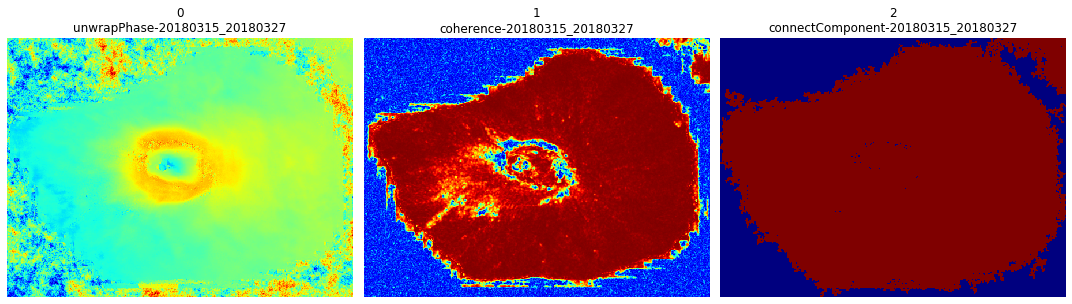

In [6]:
view('./INPUTS/ifgramStack.h5 20180315_20180327 --nrows 1 --ncols 3') #plot all data within one interferogram

#### ./INPUTS/geometry*.h5

The ./INPUTS/geometryRadar.h5 file contains all geometry related data, including height, latitude, longitude, incidence angle, etc. If these files are in geo coordinates, then the output file will be geometryGeo.h5.

Note that for **ISCE**, the lookup files (`lat.rdr and lon.rdr`) are in radar coordinates and are loaded into ./INPUTS/geometryRadar.h5 file as "latitude" and "longitude" dataset; while **GAMMA and ROI_PAC** lookup files (`sim*.UTM_TO_RDC and geomap*.trans`) are in geo coordinates and are loaded into ./INPUTS/geometryGeo.h5 file as "azimuthCoord" and "rangeCoord" dataset.
</div>

In [7]:
!info.py ./INPUTS/geometryRadar.h5 --compact

******************** Basic File Info ************************
file name: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                  5
  ANTENNA_SIDE                            -1
  AZIMUTH_PIXEL_SIZE                      78.08212603857966
  CENTER_LINE_UTC                         42584.0
  DATA_TYPE                               DOUBLE
  EARTH_RADIUS                            6337286.638938101
  FILE_LENGTH                             450
  FILE_PATH                               /Users/yunjunz/work/FernandinaSenDT128/ISCE/merged/geom_master/hgt.rdr
  FILE_TYPE                               geometry
  HEADING                                 53.4583740234375
  HEIGHT                                  698834.2261352595
  LAT_REF1                                -0.27142282744993307
  LAT_REF2                      

view.py ./INPUTS/geometryRadar.h5 --noverbose --notick --noaxis


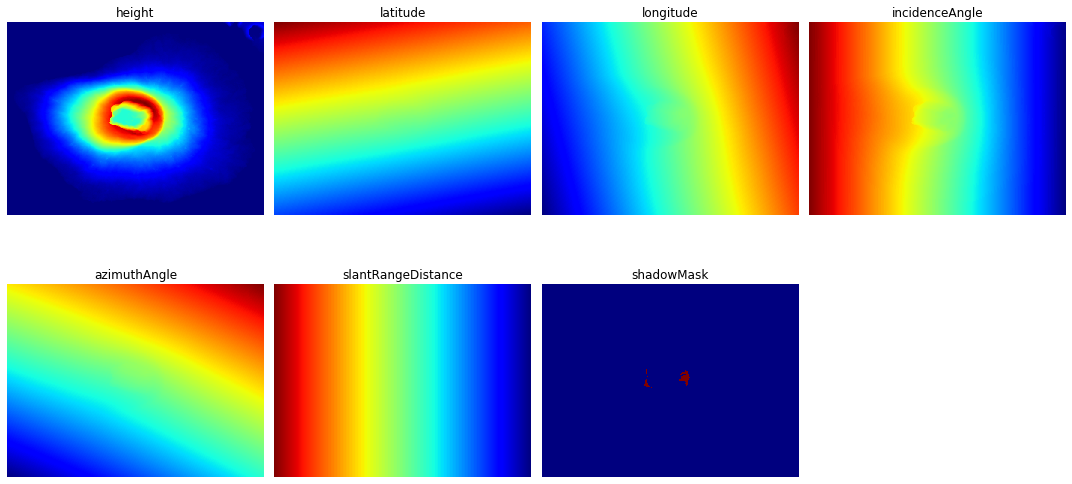

In [8]:
view('./INPUTS/geometryRadar.h5')

### 2.2 Select reference point

This step adds the reference point information into the **./INPUTS/ifgramStack.h5** by adding the metadata **REF_Y/X** (and REF_LAT/LON if input dataset is geocoded). The reference point should have valid phase (not NaN or zero) in all interferograms.    

The reference pixel can be selected in two ways:
1. randomly among the pixels with high average spatial coherence (default threshold is 0.85).
2. specified using prior knowledge of the study area `(recommended)`. The reference pixel should be:
   1. located in a coherent area;
   2. not be affected by strong atmospheric turbulence such as ionospheric streaks; 
   3. close to and with similar elevation as the area of interest to minimize the impact of the spatially correlated atmospheric delay. For example, Chaussard et al. (2013) and Morales-Rivera et al. (2016) studied volcano deformation using reference points on inactive, neighboring volcanoes.  
   
The corresponding template options are:
```cfg
## 1.1 Reference in Space
## reference all interferograms to one common point in space
## auto - randomly select a pixel with coherence > minCoherence
pysar.reference.yx            = auto   #[257,151 / auto]
pysar.reference.lalo          = -0.30,-91.43   #[31.8,130.8 / auto]
pysar.reference.coherenceFile = auto   #[filename], auto for avgSpatialCoh.h5
pysar.reference.minCoherence  = auto   #[0.0-1.0], auto for 0.85, minimum coherence for auto method
pysar.reference.maskFile      = auto   #[filename / no], auto for maskConnComp.h5
```
   
This step also generates the following auxiliary files:
+ avgSpatialCoh.h5: the average spatial coherence among all interferograms.
+ maskSpatialCoh.h5 : mask file from the average spatial coherence with min value of 0.7
+ maskConnComp.h5: the common connected components among all interferograms.

In [10]:
!pysarApp.py FernandinaSenDT128.txt --dostep reference_point

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['reference_point']
Remaining steps: ['stack_interferograms', 'correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/F

In [11]:
!ls -l

total 3912
-rw-r--r--  1 yunjunz  staff     1872 Feb  5 22:13 FernandinaSenDT128.txt
drwxr-xr-x  6 yunjunz  staff      204 Mar 16 01:38 INPUTS
-rw-r--r--  1 yunjunz  staff  1109480 Mar 16 01:38 avgSpatialCoh.h5
-rw-r--r--  1 yunjunz  staff   288664 Mar 16 01:38 maskConnComp.h5
-rw-r--r--  1 yunjunz  staff   288664 Mar 16 01:40 maskSpatialCoh.h5
-rw-r--r--  1 yunjunz  staff    12809 Mar 16 01:38 pysarApp_template.txt
-rw-r--r--  1 yunjunz  staff   287920 Feb  6 16:20 waterMask.h5


In [12]:
!info.py ./INPUTS/ifgramStack.h5 | egrep 'REF_'    #attribute related to the reference point

  REF_X                                   156
  REF_Y                                   76


### 2.3 Average velocity from interferogram stacking

This step generates the average phase velocity (avgPhaseVelocity.h5) using traditional stacking technique (Zebker et al., 1997) by dividing the unwrapped interferometric phase by their temporal baselines and averaging all interferograms. The average phase velocity provides a **quick assessment** of possible ground deformation.

In [13]:
!pysarApp.py FernandinaSenDT128.txt --dostep stack_interferograms

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['stack_interferograms']
Remaining steps: ['correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/P

view.py avgPhaseVelocity.h5 --noverbose --notick --noaxis


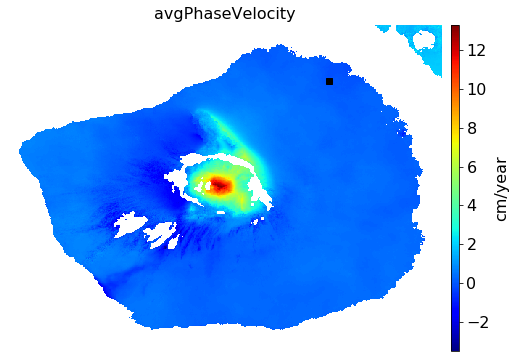

In [14]:
view('avgPhaseVelocity.h5')     # plot the stacking result

### 2.4 Phase-unwrapping error correction (optional)

This step corrects phase-unwrapping errors in the stack of interferograms, supporting the following methods (Yunjun et al., 2019):   
+ bridging
+ phase_closure
+ bridging+phase_closure    
    
If turn on, it will add new dataset named as "unwrapPhase_bridging" or "unwrapPhase_phaseClosure" or "unwrapPhase_bridging_phaseClosure" into the ./INPUTS/ifgramStack.h5 file. The corresonding template options are:
```cfg
pysar.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
pysar.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
pysar.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for no
pysar.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 150, radius in pixel of circular area around bridge ends
```

In this dataset, we turn off (by default) this option and skip this step.

### 2.5 Network modification (optional)

This step identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion. This is done by setting the corresponding dataset `dropIfgram = True` in ./INPUTS/ifgramStack.h5 file. The corresponding template options are:

```cfg
## 3.1.1 Coherence-based network modification = MST + Threshold, by default
## 1) calculate a average coherence value for each interferogram using spatial coherence and input mask (with AOI)
## 2) find a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
## 3) for all interferograms except for MST's, exclude those with average coherence < minCoherence.
pysar.network.coherenceBased  = auto  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
pysar.network.keepMinSpanTree = auto  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
pysar.network.minCoherence    = auto  #[0.0-1.0], auto for 0.7
pysar.network.maskFile        = auto  #[file name, no], auto for maskConnComp.h5, no for all pixels
pysar.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
pysar.network.aoiLALO         = auto  #[lat0:lat1,lon0:lon1 / no], auto for no - use the whole area
## 3.1.2 Network modification based on temporal/perpendicular baselines, date etc.
pysar.network.tempBaseMax     = auto  #[1-inf, no], auto for no, maximum temporal baseline in days
pysar.network.perpBaseMax     = auto  #[1-inf, no], auto for no, maximum perpendicular spatial baseline in meter
pysar.network.connNumMax      = auto  #[1-inf, no], auto for no, maximum number of neighbors for each acquisition
pysar.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no
pysar.network.excludeDate     = auto  #[20080520,20090817 / no], auto for no
pysar.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
pysar.network.startDate       = auto  #[20090101 / no], auto for no
pysar.network.endDate         = auto  #[20110101 / no], auto for no
```

<div class="alert alert-info">
<b>TIP:</b> 
For coherence-based network modification, a customized area of interest (AOI) that includes the low coherent areas surrounding the areas with coherent phase-unwrapping error is highly recommended. Such as the blue rectangle in the figure below.
</div>

<p align="center">
  <img width=600, src="docs/images/net_modification.jpg">
</p>    
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>    

In this dataset, we turn off (by default) this option and skip this step, becuase there is no remaining phase-unwrapping error on coherent pixels.

In [15]:
!pysarApp.py FernandinaSenDT128.txt --dostep modify_network

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['modify_network']
Remaining steps: ['invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template

#### Plot network

The network configuration information is plotted and saved into the following files:

+ Network.pdf: network configuration in temporal and perpendicular baseline plane.
+ CoherenceMatrix.pdf: average spatial coherence of each interferogram.
+ CoherenceHistory.pdf: the min/max average spatial coherence of all interferograms for each acquisition.
+ BperpHistory.pdf: the perpendicular spatial baseline history of the dataset.

The network configuartion and coherence matrix is re-plotted in the cell below:

['ifgramStack_coherence_spatialAvg.txt'] exists and is newer than ['./INPUTS/ifgramStack.h5', 'maskConnComp.h5'] --> skip.
ifgramStack_coherence_spatialAvg.txt already exists, read it directly
max perpendicular baseline: 214.31 m
max temporal      baseline: 96.0 days


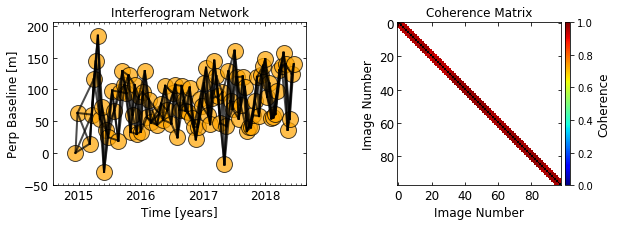

In [16]:
def plot_network(stack_file='./INPUTS/ifgramStack.h5'):
    date_list = ifgramStack(stack_file).get_date_list(dropIfgram=False)
    pbase_list = ifgramStack(stack_file).get_perp_baseline_timeseries(dropIfgram=False)
    date12_list = ifgramStack(stack_file).get_date12_list(dropIfgram=False)
    date12_list_keep = ifgramStack(stack_file).get_date12_list(dropIfgram=True)
    date12_list_drop = sorted(list(set(date12_list) - set(date12_list_keep)))
    coh_list = ut.spatial_average(stack_file, datasetName='coherence', maskFile='maskConnComp.h5', saveList=True, checkAoi=False)[0]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 3])
    pp.plot_network(axs[0], date12_list, date_list, pbase_list, date12List_drop=date12_list_drop)
    pp.plot_coherence_matrix(axs[1], date12_list, coh_list, date12_list_drop)
    plt.show()
    return

plot_network(stack_file='./INPUTS/ifgramStack.h5')

### 2.6 Network inversion

This step inverts the network of interferograms for the raw phase time-series. Note that this raw phase time-series includes contributions from ground deformation, atmospheric delay and topographic residual caused by DEM error. The following **weighted least squares (WLS) inversions** methods are supported:

+ Inverse of covariance
+ Finisher Information Matrix (FIM)
+ Spatial coherence
+ Uniform / no weighting

The corresponding template options are:   

```cfg
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## 1) var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## 2) fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## 3) coh - use coherence as weight (Perissin & Wang, 2012)
## 4) no  - uniform weight (Berardino et al., 2002)
## mask options for unwrapPhase of each interferogram before inversion (recommed if weightFunct=no):
## 1) coherence        - mask out pixels with spatial coherence < maskThreshold
## 2) connectComponent - mask out pixels with False/0 value
## 3) no               - no masking [recommended].
## Temporal coherence is calculated and used to generate final mask (Pepe & Lanari, 2006, IEEE-TGRS)
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
pysar.networkInversion.weightFunc      = auto #[var / fim / coh / no], auto for var
pysar.networkInversion.maskDataset     = auto #[coherence / connectComponent / no], auto for no
pysar.networkInversion.maskThreshold   = auto #[0-1], auto for 0.4
pysar.networkInversion.minRedundancy   = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition
pysar.networkInversion.waterMaskFile   = auto #[filename / no], auto for no
pysar.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity or phase
pysar.networkInversion.residualNorm    = auto #[L2 ], auto for L2, norm minimization solution
pysar.networkInversion.minTempCoh      = auto #[0.0-1.0], auto for 0.7, min temporal coherence for mask
pysar.networkInversion.minNumPixel     = auto #[int > 0], auto for 100, min number of pixels in mask above
```

It outputs the following files:   

```cfg
timeseries.h5         #raw phase time-series in unit of meters.
temporalCoherence.h5  #temporal coherence (Pepe et al., 2006).
maskTempCoh.h5        #mask of reliable pixels with min temporal coherence of "minTempCoh" value.
numInvIfgram.h5       #number of interferograms used in the inversion for each pixel.
                      #This number varies for different pixels if "maskDataset" is not "no".
```

In [17]:
!pysarApp.py FernandinaSenDT128.txt --dostep invert_network

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunj

view.py timeseries.h5 --notitle --wrap --wrap-range -5 5 -u cm --noverbose --notick --noaxis


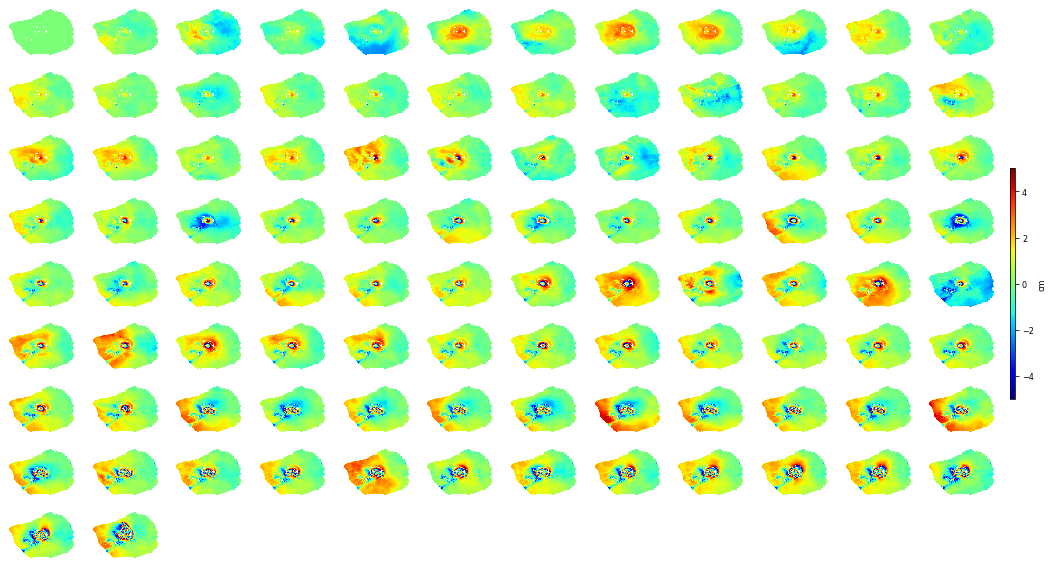

In [18]:
#plot the raw phase time-series and re-wrapped into [-5, 5) cm
view('timeseries.h5 --notitle --wrap --wrap-range -5 5 -u cm')

view.py temporalCoherence.h5 --noverbose --notick --noaxis


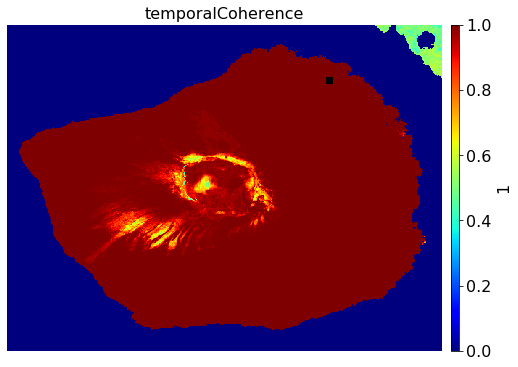

view.py maskTempCoh.h5 --noverbose --notick --noaxis


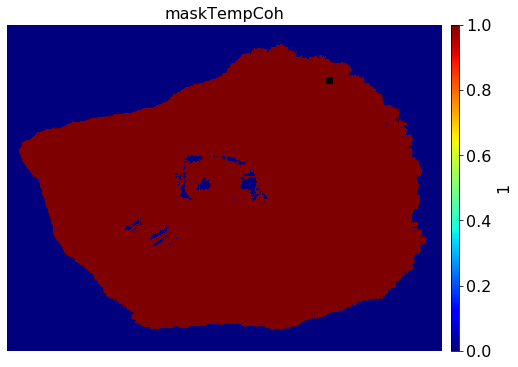

In [19]:
view('temporalCoherence.h5')
view('maskTempCoh.h5')

### 2.7 Correct local oscillator drift (for Envisat)

Data from Envisat’s Advanced Synthetic Aperture Radar (ASAR) instrument include a phase ramp in range direction due to timing errors. This step corrects the local oscillator drift using the empirical model given by Marinkovic and Larsen (2013). It's automatically turned ON for Envisat data and OFF for all the other dataset.

In [20]:
!pysarApp.py FernandinaSenDT128.txt --dostep correct_LOD

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['correct_LOD']
Remaining steps: ['correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/Fernandin

### 2.8 Tropospheric delay correction

This step corrects the tropospheric phase delay. Two methods are supported:

+ Global Atmospheric Models (GAMs) (Jolivet et al., 2011; 2014; PyAPS needs to be installed).
+ Empirical relationship between stratified tropospheric delay and topography (Doin et al., 2009).

The corresponding template options are:

```cfg
## correct tropospheric delay using the following methods:
## a. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011, GRL, need to install PyAPS)
## b. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
## For pyaps method with the most recent SAR data, there will be GAM data missing due to latency
## then the correction will be applied to dates with GAM data available and skipped for the others.
pysar.troposphericDelay.method       = auto  #[pyaps / height_correlation / no], auto for pyaps
pysar.troposphericDelay.weatherModel = auto  #[ERA / MERRA / NARR], auto for ECMWF, for pyaps method
pysar.troposphericDelay.weatherDir   = auto  #[path2directory], auto for "./../WEATHER"
pysar.troposphericDelay.polyOrder    = auto  #[1 / 2 / 3], auto for 1, for height_correlation method
pysar.troposphericDelay.looks        = auto  #[1-inf], auto for 8, for height_correlation, number of looks
                                             #applied to interferogram while estimating the empirical ratio.
```
It outputs:
+ timeseries_ECMWF.h5: the troposphere-corrected time-series (ECMWF data is selected in this case).
+ ECMWF.h5: the estimated tropospheric phase delay time-series (for pyaps method only).

In [21]:
!pysarApp.py FernandinaSenDT128.txt --dostep correct_troposphere

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['correct_troposphere']
Remaining steps: ['deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR

view.py timeseries_ECMWF.h5 --notitle --wrap --wrap-range -5 5 --noverbose --notick --noaxis


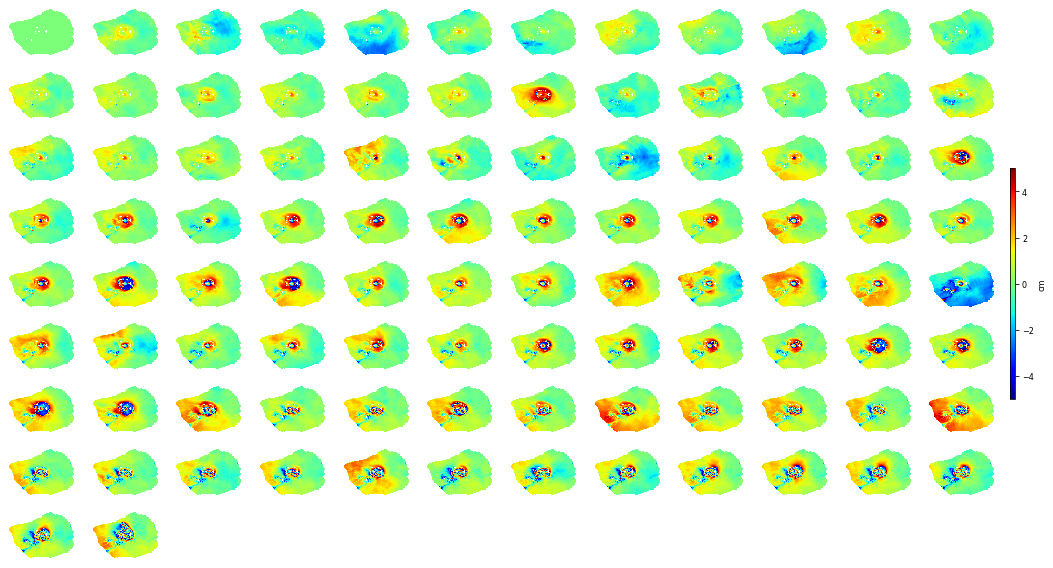

In [22]:
view('timeseries_ECMWF.h5 --notitle --wrap --wrap-range -5 5')

### 2.9 Phase deramping (optional)

This step estimate and remove a linear or quadratic ramp for each acquisition based on the phase of the reliable pixels. It's recommended for localized deformation signals, such as volcanic deformation, landslides and city subsidence; but not recommeded for long spatial wavelength deformation signals, such as interseismic deformation.

The cooresponding template options are:

```cfg
## estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## recommended for localized deformation signals, i.e. volcanic deformation, landslide and subsidence, etc.
pysar.deramp          = auto  #[no / linear / quadratic], auto for no - no ramp will be removed
pysar.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation
```

It outputs a new time-series HDF5 file with suffix _ramp_: timeseries_ECMWF_ramp.h5 in this example case.

In [23]:
!pysarApp.py FernandinaSenDT128.txt --dostep deramp

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


view.py timeseries_ECMWF_ramp.h5 --notitle --wrap --wrap-range -5 5 --noverbose --notick --noaxis


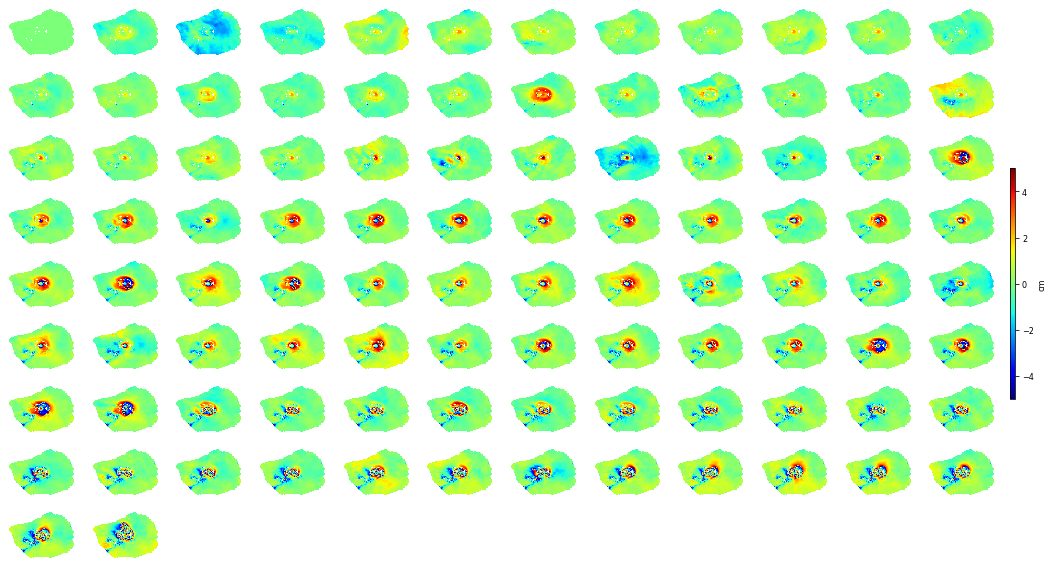

In [24]:
view('timeseries_ECMWF_ramp.h5 --notitle --wrap --wrap-range -5 5')

### 2.10 Topographic residual (DEM error) correction

This step corrects the phase residual caused by the inaccuracy of DEM (DEM error) using its relationship with the perpendicular baseline time-series (Fattahi and Amelung, 2013, IEEE-TGRS). The corresponding template options are:

```cfg
## Specify stepFuncDate option if you know there are sudden displacement jump in your area,
## i.e. volcanic eruption, or earthquake, and check timeseriesStepModel.h5 afterward for their estimation.
## [fast option available but not best]
pysar.topographicResidual               = auto  #[yes / no], auto for yes
pysar.topographicResidual.polyOrder     = auto  #[1-inf], auto for 2, poly order of temporal deformation model
pysar.topographicResidual.phaseVelocity = auto  #[yes / no], auto for no - phase, use phase velocity for error estimation
pysar.topographicResidual.stepFuncDate  = auto  #[20080529,20100611 / no], auto for no, date of step jump
pysar.topographicResidual.excludeDate   = auto  #[20070321 / txtFile / no], auto for exclude_date.txt,
                                                # dates exlcuded for error estimation
```

It outputs:
+ timeseries_ECMWF_ramp_demErr.h5: the topographic residual corrected time-series.
+ timeseriesResidual.h5: residual phase time-series of this least square inversion.
+ demErr.h5: the estimated DEM error.

In [25]:
!pysarApp.py FernandinaSenDT128.txt --dostep correct_topography

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


********

view.py timeseries_ECMWF_ramp_demErr.h5 --notitle --wrap --wrap-range -5 5 --noverbose --notick --noaxis


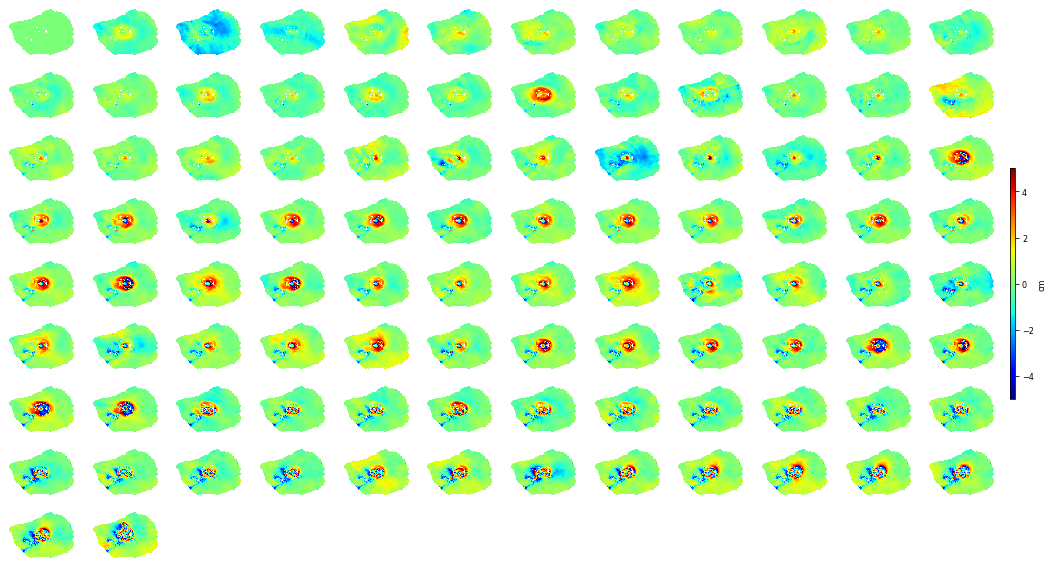

In [26]:
view('timeseries_ECMWF_ramp_demErr.h5 --notitle --wrap --wrap-range -5 5')

### 2.11 Phase residual RMS for noise evaluation

This step calculates the Root Mean Square (RMS) of the residual phase time-series for each acquisition; then it:
1. selects the date with the minimum RMS value as the optimal reference date.
2. detects the noisy acquisitions with RMS beyond the outlier detection threshold.

The corresponding template options are:
```cfg
## To get rid of long wavelength component in space, a ramp is removed for each epoch.
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
pysar.residualRms.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
pysar.residualRms.ramp     = auto  #[quadratic / linear / no], auto for quadratic
pysar.residualRms.cutoff   = auto  #[0.0-inf], auto for 3
```

It outputs:
+ rms_timeseriesResidual_ramp.txt: for RMS value of each acquisition
+ rms_timeseriesResidual_ramp.pdf: plot of the rms_timeseriesResidual_ramp.txt
+ reference_date.txt: date in YYYYMMDD format for the optional reference date
+ exclude_date.txt: date(s) in YYYYMMDD format for the noisy acquisitions (if at least one is detected).

In [27]:
!pysarApp.py FernandinaSenDT128.txt --dostep residual_RMS

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - re

In [28]:
!head rms_timeseriesResidual_ramp.txt

# Root Mean Square in space for each epoch of timeseries
# Timeseries file: timeseriesResidual_ramp.h5
# Mask file: maskTempCoh.h5
# Date		RMS (m)
20141213	0.005964733
20141225	0.0053763115
20150307	0.0118454555
20150319	0.0037896754
20150331	0.0048516523
20150412	0.0026863038


In [29]:
!cat reference_date.txt    #auto selected optimal reference date.

20150611


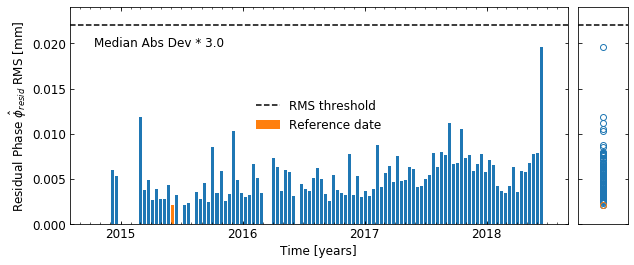

In [30]:
## plot the RMS value
from pysar.timeseries_rms import plot_rms_bar
txtContent = np.loadtxt('./rms_timeseriesResidual_ramp.txt', dtype=bytes).astype(str)
rms_list = [float(i) for i in txtContent[:, 1]]
date_list = [i for i in txtContent[:, 0]]
fig, ax = plt.subplots(figsize=[10, 4])
ax = plot_rms_bar(ax, date_list, rms_list)
plt.show()

### 2.12 Change reference date

This step changes the reference date of all phase time-series files, based on the input template option:

```cfg
## no     - do not change the default reference date (1st date)
pysar.reference.date  = auto   #[reference_date.txt / 20090214 / no], auto for reference_date.txt
```

This step operates on the existing time-series files and does not output new files.

<div class="alert alert-warning">
<b>Note:</b> 
The optimal reference date (default option) gives the time-series plot a "clean" looks only. Changing the reference is equivalent to adding a constant to the displacement time series, which does not change the velocity or any other information derived from the displacement time series.
</div>

In [31]:
!pysarApp.py FernandinaSenDT128.txt --dostep reference_date

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - reference_date ***

### 2.13 Velocity

This step estimates the average velocity as the slope of the best fitting line to the displacement time-series. Noisy acquisitions (identified in "residual_RMS" step) from exclude_date.txt file are excluded by default during the estimation. 

#### Algorithm:
Given the displacement time-series in meters $d^i, i=1,...,N$, with $d^i = -\frac{\lambda}{4\pi}\phi_{dis}^i$, the average velocity is estimated as:

$d^i = vt_i + c, i=1,...,N$

The standard deviation of the estimated velocity is given by equation (10) in Fattahi and Amelung (2015, JGR) as:

$\sigma_v = \sqrt{\frac{\sum_{i=1}^N (d_i - \hat d_i)^2}{(N-2)\sum_{i=1}^N (t_i - \bar t)^2}}$
     
     
The corresponding template options are:

```cfg
## estimate linear velocity from time-series, and from tropospheric delay file if exists.
pysar.velocity.excludeDate = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt
pysar.velocity.startDate   = auto   #[20070101 / no], auto for no
pysar.velocity.endDate     = auto   #[20101230 / no], auto for no
```

It outputs:
+ velocity.h5: the estimated average velocity and its standard deviation from displacement time-series.
+ velocityEcmwf.h5: same as above but from the tropospheric delay time-series, to see the potential bias introduced by troposphere if it was not corrected.

In [32]:
!pysarApp.py FernandinaSenDT128.txt --dostep velocity

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - velocity ********************
timese

In [33]:
!info.py velocity.h5 --compact

******************** Basic File Info ************************
file name: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/velocity.h5
file type: velocity
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                     5
  ANTENNA_SIDE                               -1
  AZIMUTH_PIXEL_SIZE                         78.08212603857966
  CENTER_LINE_UTC                            42584.0
  DATA_TYPE                                  float32
  DATE12                                     20141213_20180619
  EARTH_RADIUS                               6337286.638938101
  END_DATE                                   20180619
  FILE_LENGTH                                450
  FILE_PATH                                  /Users/yunjunz/work/FernandinaSenDT128/PYSAR/timeseries_ECMWF_ramp_demErr.h5
  FILE_TYPE                                  velocity
  HEADING                                    53.4583740234375
  HEIGHT     

view.py velocity.h5 --noverbose --notick --noaxis


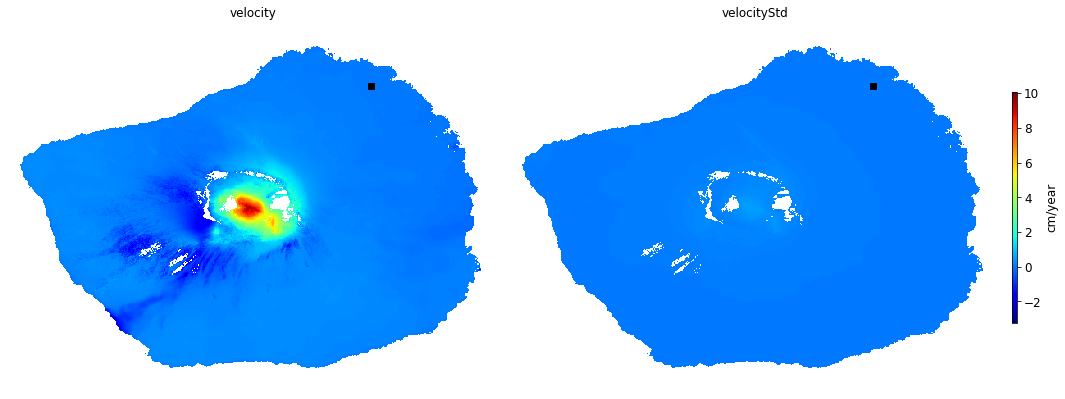

In [34]:
view('velocity.h5')

view.py velocityEcmwf.h5 --noverbose --notick --noaxis


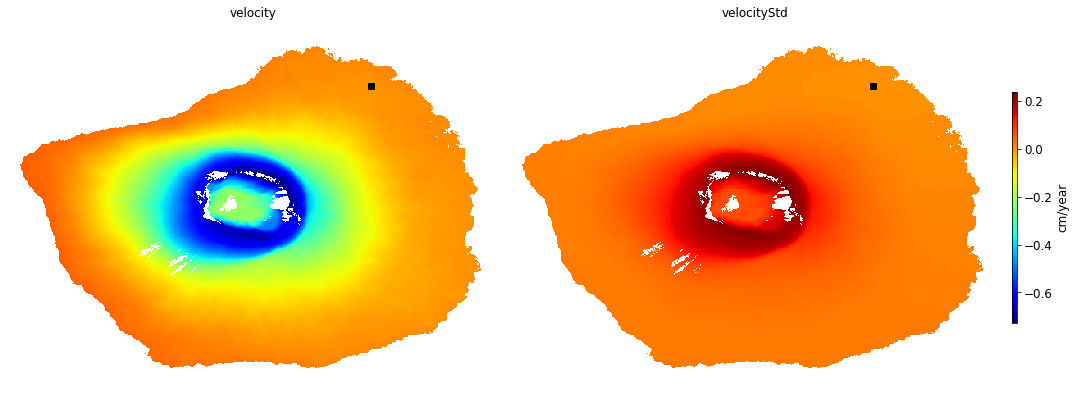

In [35]:
view('velocityEcmwf.h5')

### 2.14 Geocoding (optional)

This step resamples the following files from radar coordinates to geo coordinates. It's skipped if input dataset is in geo coordiantes already. The corresponding template options are:

```cfg
pysar.geocode              = auto  #[yes / no], auto for yes
pysar.geocode.SNWE         = auto  #[-1.2,0.5,-92,-91 / no ], auto for no, coverage in S N W E in degree
pysar.geocode.latStep      = auto  #[0.0-90.0 / None], auto for None (calculate from lookup file)
pysar.geocode.lonStep      = auto  #[0.0-180.0 / None], auto for None (calculate from lookup file)
pysar.geocode.interpMethod = auto  #[nearest], auto for nearest, interpolation method
pysar.geocode.fillValue    = auto  #[np.nan, 0, ...], auto for np.nan, fill value for outliers.
```

It outputs the following files into **./GEOCODE** folder:
+ ./GEOCODE/geo_geometryRadar.h5
+ ./GEOCODE/geo_maskTempCoh.h5
+ ./GEOCODE/geo_temporalCoherence.h5
+ ./GEOCODE/geo_timeseries_ECMWF_ramp_demErr.h5
+ ./GEOCODE/geo_velocity.h5

In [36]:
!pysarApp.py FernandinaSenDT128.txt --dostep geocode

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - geocode ********************
create directory: /

In [37]:
!ls -l ./GEOCODE

total 233944
-rw-r--r--  1 yunjunz  staff    6872768 Mar 16 01:49 geo_geometryRadar.h5
-rw-r--r--  1 yunjunz  staff     290352 Mar 16 01:49 geo_maskTempCoh.h5
-rw-r--r--  1 yunjunz  staff    1111168 Mar 16 01:49 geo_temporalCoherence.h5
-rw-r--r--  1 yunjunz  staff  109287088 Mar 16 01:49 geo_timeseries_ECMWF_ramp_demErr.h5
-rw-r--r--  1 yunjunz  staff    2208976 Mar 16 01:49 geo_velocity.h5


view.py ./GEOCODE/geo_velocity.h5 velocity --dem ./GEOCODE/geo_geometryRadar.h5 --figsize 12 12  --noverbose --notick --noaxis


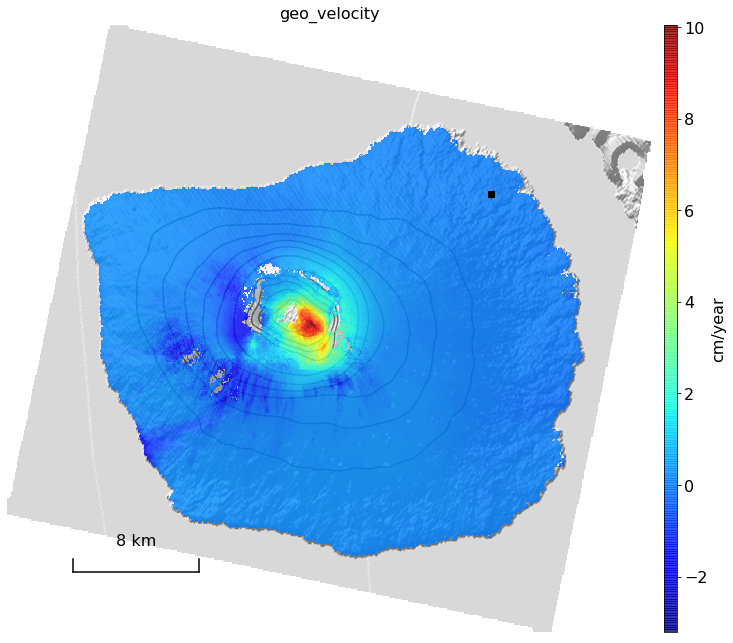

In [38]:
# plot velocity on top of shaded topography
view('./GEOCODE/geo_velocity.h5 velocity --dem ./GEOCODE/geo_geometryRadar.h5 --figsize 12 12 ')

### 2.15 Output to Google Earth format (optional)

This step saves the geocoded velocity to the .kmz format. The corresponding template option is:  

```cfg
pysar.save.kmz             = auto   #[yes / no], auto for yes, save geocoded velocity to Google Earth KMZ file
```

It output the ./GEOCODE/geo_velocity.kmz file.

In [48]:
!pysarApp.py FernandinaSenDT128.txt --dostep google_earth

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--dostep option enabled, disable the plotting at the end of the processing.
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt'] --> skip.
read custom template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - google_earth ********************
creating Google Earth KMZ

In [49]:
!open ./GEOCODE/geo_velocity.kmz   #Open KMZ file in Google Earth, which needs to be installed.

### 2.16 Save to HDF-EOS5 format (optional)

This step saves the geocoded displacement time-series into [HDF-EOS5](https://earthdata.nasa.gov/user-resources/standards-and-references/hdf-eos5) format. It is well-suited for **data sharing**. This format is used in University of Miami's insarmaps website: https://insarmaps.miami.edu.

The corresponding template options are:

```cfg
pysar.save.hdfEos5         = auto   #[yes / no], auto for no, save time-series to HDF-EOS5 format
pysar.save.hdfEs5.update   = auto   #[yes / no], auto for no, put XXXXXXXX as endDate in output filename
pysar.save.hdfEos5.subset  = auto   #[yes / no], auto for no, put subset range info   in output filename
```

The output file includes 3D displacement time-series, temporal coherence, temporal coherence mask and all geometry related dataset: height, incidenceAngle, slantRangeDistance etc. For details on the naming convention and dataset structure, check the wiki page [here](https://github.com/yunjunz/PySAR/wiki/HDF-EOS5). For this example dataset, it would output a file: S1_IW12_128_0593_0597_20141213_20180619.he5 if turn on. However, it's turn off and skipped here.

## 3. pysarApp.py non-stop processing

Once the user gets familiar with the template setting, one can setup all the custom modified configurations (in the custom template file - recommeded), and run pysarApp.py with a single command-line call to process all steps:

```
pysarApp.py FernandinaSenDT128.txt
```

### 3.1 Re-run and skipping of processing steps

To facilitate the re-running process, a skipping strategy is implemented for all steps in pysarApp.py and skip steps if:

1. output files / datasets already exist and are newer than input files / datasets 
2. AND for key / time-consuming steps (unwrap error correction, network inversion, topographic residual correction, etc.):     
    all related configurations are the same as before.

Therefore, one can modified the template option and re-run pysarApp.py without specifying the start/end step, and the processing will start from where is changed and continue from there.

### 3.2 Move ./INPUTS after runing `pysarApp.py --end load_data`

**./INPUTS** folder contains everything pysarApp needs. One can move the ./INPUTS folder to anywhere PySAR is installed and re-start the whole analysis. It's well-suited for users who want to play around the analysis on their local laptop after the massive InSAR stack processing on the High Performance Computer (HPC) or Cloud.

## Relevant references:

+ Berardino, P., G. Fornaro, R. Lanari, and E. Sansosti (2002), A new algorithm for surface deformation monitoring based on small baseline differential SAR interferograms, Geoscience and Remote Sensing, IEEE Transactions on, 40(11), 2375-2383, doi:10.1109/TGRS.2002.803792.

+ Chaussard, E., F. Amelung, and Y. Aoki (2013), Characterization of open and closed volcanic systems in Indonesia and Mexico using InSAR time series, Journal of Geophysical Research: Solid Earth, 118(8), 3957-3969, doi:10.1002/jgrb.50288.

+ Chen, C. W., and H. A. Zebker (2001), Two-dimensional phase unwrapping with use of statistical models for cost functions in nonlinear optimization, JOSA A, 18(2), 338-351, doi:10.1364/JOSAA.18.000338.

+ Doin, M. P., C. Lasserre, G. Peltzer, O. Cavalié, and C. Doubre (2009), Corrections of stratified tropospheric delays in SAR interferometry: Validation with global atmospheric models, Journal of Applied Geophysics, 69(1), 35-50, doi:10.1016/j.jappgeo.2009.03.010.

+ Fattahi, H., and F. Amelung (2013), DEM Error Correction in InSAR Time Series, Geoscience and Remote Sensing, IEEE Transactions on, 51(7), 4249-4259, doi:10.1109/TGRS.2012.2227761.

+ Fattahi, H., and F. Amelung (2015), InSAR bias and uncertainty due to the systematic and stochastic tropospheric delay, Journal of Geophysical Research: Solid Earth, 120(12), 8758-8773, doi:10.1002/2015JB012419.

+ Fattahi, H., P. Agram, and M. Simons (2016), A Network-Based Enhanced Spectral Diversity Approach for TOPS Time-Series Analysis, IEEE Transactions on Geoscience and Remote Sensing, 55(2), 777-786, doi:10.1109/TGRS.2016.2614925.

+ Jolivet, R., R. Grandin, C. Lasserre, M. P. Doin, and G. Peltzer (2011), Systematic InSAR tropospheric phase delay corrections from global meteorological reanalysis data, Geophysical Research Letters, 38(17), L17311, doi:10.1029/2011GL048757.

+ Marinkovic, P., and Y. Larsen (2013), Consequences of long-term ASAR local oscillator frequency decay - An empirical study of 10 years of data, paper presented at Proceedings of the Living Planet Symposium (abstract), European Space Agency, Edinburgh, U. K.

+ Morales Rivera, A. M., F. Amelung, and P. Mothes (2016), Volcano Deformation Survey over the Northern and Central Andes with ALOS InSAR Time Series, Geochemistry, Geophysics, Geosystems, 17, 2869-2883, doi:10.1002/2016GC006393.

+ Pepe, A., and R. Lanari (2006), On the extension of the minimum cost flow algorithm for phase unwrapping of multitemporal differential SAR interferograms, Geoscience and Remote Sensing, IEEE Transactions on, 44(9), 2374-2383, doi:10.1109/TGRS.2006.873207.

+ Rosen, P. A., S. Hensley, G. Peltzer, and M. Simons (2004), Updated repeat orbit interferometry package released, Eos Trans. AGU, 85(5), 47-47, doi:10.1029/2004EO050004.

+ Rosen, P. A., E. Gurrola, G. F. Sacco, and H. Zebker (2012), The InSAR scientific computing environment, paper presented at EUSAR 2012, 23-26 April 2012.

+ Werner, C., U. Wegmüller, T. Strozzi, and A. Wiesmann (2000), Gamma SAR and interferometric processing software, paper presented at Proceedings of the ERS-Envisat symposium, Gothenburg, Sweden.

+ Yunjun, Z., H. Fattahi, F. Amelung (2019), InSAR time series analysis: error correction and noise reduction, Remote Sensing of Environment (under review). 

+ Zebker, H. A., P. A. Rosen, and S. Hensley (1997), Atmospheric effects in interferometric synthetic aperture radar surface deformation and topographic maps, Journal of Geophysical Research: Solid Earth, 102(B4), 7547-7563, doi:10.1029/96JB03804.